### t-SNE of the proteome-average UniRep vector of 4 model organisms (human, mouse, dog, zebrafish)

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import random
import os
import Levenshtein
import fastcluster as fc
import scipy.cluster.hierarchy as hier
import pickle
# To allow imports from common directory
sys.path.append('../../')
from common.plot_style_utils import set_pub_plot_context, rep_names, save_for_pub
from common.embedding_tools import lev_dist_matrix, lev_sim_matrix

%matplotlib inline
random.seed(42)
np.random.seed(42)

Compute the mean representation within each organism. Use this to hierarchical cluster organisms, and project the mean organism reps into the PCA basis learned from Surge's 100K uniprot sequences.

In [2]:
meta = pd.read_csv("/Users/aniton/Documents/iMolecule/data/meta.csv")
meta.columns =["id", "seq", "description", "name", "organism"]
meta

,id,seq,description,name,organism
0,sp|O94910|AGRL1_HUMAN,MARLAAVLWNLCVTAVLVTSATQGLSRAGLPFGLMRRELACEGYPI...,sp|O94910|AGRL1_HUMAN Adhesion G protein-coupl...,sp|O94910|AGRL1_HUMAN,human
1,sp|Q80TR1|AGRL1_MOUSE,MARLAAALWSLCVTTVLVTSATQGLSRAGLPFGLMRRELACEGYPI...,sp|Q80TR1|AGRL1_MOUSE Adhesion G protein-coupl...,sp|Q80TR1|AGRL1_MOUSE,mouse
2,sp|P28222|5HT1B_HUMAN,MEEPGAQCAPPPPAGSETWVPQANLSSAPSQNCSAKDYIYQDSISL...,sp|P28222|5HT1B_HUMAN 5-hydroxytryptamine rece...,sp|P28222|5HT1B_HUMAN,human
3,sp|P79250|5HT1B_CANLF,MEAAGAPCAPPPPAGSQTGAPPANLSSAPHNCSAEGYIYQDSVALP...,sp|P79250|5HT1B_CANLF 5-hydroxytryptamine rece...,sp|P79250|5HT1B_CANLF,dog
4,sp|P28334|5HT1B_MOUSE,MEEQGIQCAPPPPAASQTGVPLTNLSHNCSADGYIYQDSIALPWKV...,sp|P28334|5HT1B_MOUSE 5-hydroxytryptamine rece...,sp|P28334|5HT1B_MOUSE,mouse
5,sp|P34969|5HT7R_HUMAN,MMDVNSSGRPDLYGHLRSFLLPEVGRGLPDLSPDGGADPVAGSWAP...,sp|P34969|5HT7R_HUMAN 5-hydroxytryptamine rece...,sp|P34969|5HT7R_HUMAN,human
6,sp|P32304|5HT7R_MOUSE,MMDVNSSGRPDLYGHLRSLILPEVGRRLQDLSPDGGAHSVVSSWMP...,sp|P32304|5HT7R_MOUSE 5-hydroxytryptamine rece...,sp|P32304|5HT7R_MOUSE,mouse
7,sp|Q9HBW9|AGRL4_HUMAN,MKRLPLLVVFSTLLNCSYTQNCTKTPCLPNAKCEIRNGIEACYCNM...,sp|Q9HBW9|AGRL4_HUMAN Adhesion G protein-coupl...,sp|Q9HBW9|AGRL4_HUMAN,human
8,sp|Q923X1|AGRL4_MOUSE,MRLLPLLVGFSTLLNCSYTQNCSKTTCLPNAKCEVHNGVEACFCSQ...,sp|Q923X1|AGRL4_MOUSE Adhesion G protein-coupl...,sp|Q923X1|AGRL4_MOUSE,mouse
9,sp|Q7SY09|AGRL4_DANRE,MKLLLFAAWFSSLLDPCRFLDICQSCHPNADCDDICKCRTGYTGNG...,sp|Q7SY09|AGRL4_DANRE Adhesion G protein-coupl...,sp|Q7SY09|AGRL4_DANRE,zebrafish


#### UniRep модель для представления gpcr в каждом протеоме

In [3]:
reps = np.memmap("/Users/aniton/Documents/iMolecule/data/avg_hidden_full_53.memnpy",
                     mode="r",
                     dtype=np.float32,
                     shape=(10, 1900)
                     )
reps

memmap([[ 0.00409179, -0.02905684,  0.05819068, ..., -0.00640377,
          0.05548698,  0.03035289],
        [ 0.0080851 , -0.00502201,  0.04631828, ..., -0.00594639,
          0.09829481, -0.00456978],
        [ 0.00619606,  0.12493809,  0.13175243, ...,  0.08588191,
         -0.01561721,  0.07642487],
        ...,
        [ 0.00378827, -0.03524483,  0.04061274, ...,  0.03318325,
          0.02388165,  0.06336185],
        [ 0.0031024 , -0.00694551,  0.07315227, ...,  0.04098549,
         -0.13327664,  0.24890031],
        [ 0.00289314, -0.02245093,  0.04616727, ...,  0.02191218,
          0.08017933, -0.00907807]], dtype=float32)

In [4]:
organisms = meta.organism.unique().tolist()
organisms

['human', 'mouse', 'dog', 'zebrafish']

#### (t-SNE) projection of average UniRep representations

In [5]:
organism_means = pd.DataFrame({
    "organism":organisms,
    "mean_rep":[np.mean(
                        reps[meta.organism == o],
                        axis=0
                       ) for o in organisms]
}
).set_index("organism")
organism_means

,mean_rep
organism,
human,"[0.004102793, 0.027897034, 0.080792, -0.021301..."
mouse,"[0.0045489008, -0.00036625017, 0.07418914, -0...."
dog,"[0.00600221, -0.042912822, 0.027700389, -0.007..."
zebrafish,"[0.0028931366, -0.022450926, 0.04616727, -0.01..."


In [6]:
def label_point(x, y, val, ax, fontsize=20):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']),
               fontsize=fontsize)

In [7]:
# Now lets try TSNE
tsne = TSNE(n_components=2, perplexity=12, random_state=42)
components = tsne.fit_transform(organism_means.mean_rep.tolist())

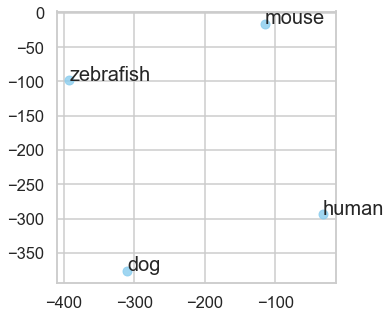

In [8]:
set_pub_plot_context()
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
x = components[:,0]
y = components[:,1]
sns.regplot(x=x, y=y, fit_reg=False, ax=ax)
label_point(pd.Series(x),pd.Series(y),
            pd.Series(organism_means.index.values)
            ,ax, fontsize=20)

In [9]:
organism_means.index.values

array(['human', 'mouse', 'dog', 'zebrafish'], dtype=object)

In [10]:
domain = {
    'celegans':"Eukarya", 
    'drosophila':"Eukarya", 
    'ecoliK12':"Bacteria", 
    'human':"Eukarya", 
    'mouse':"Eukarya", 
    'yeast':"Eukarya",
    'afischeri':"Bacteria", 
    'anolis_carolinensis':"Eukarya", 
    'aspergillus_nidulans':"Eukarya",
    'athaliana':"Eukarya", 
    'azotobacter_vinelandii':"Bacteria", 
    'bsubtilis168':"Bacteria",
    'cavia_porcellus':"Eukarya", 
    'chicken':"Eukarya", 
    'coprinopsis_cinerea':"Eukarya", 
    'cow':"Eukarya",
    'creinhardtii':"Eukarya", 
    'cryptococcus_neoformans':"Eukarya", 
    'cyanothecePCC7822':"Bacteria",
    'dog':"Eukarya", 
    'ehuxleyi':"Eukarya", 
    'halobacterium_salinarum':"Archaea", 
    'haloferax_volcanii':"Archaea",
    'macaca_mulatta':"Eukarya", 
    'maize':"Eukarya", 
    'methanococcus_maripaludis':"Archaea",
    'methanosarcina_acetivorans':"Archaea", 
    'mgenitalium':"Bacteria", 
    'mtuberculosis':"Bacteria",
    'naked_molerat':"Eukarya", 
    'neurospora_crassa':"Eukarya", 
    'oryzias_latipes':"Eukarya",
    'phage_lambda':"Virus", 
    'physcomitrella_patens':"Eukarya", 
    'pigeon':"Eukarya", 
    'pig_sus_scrofa':"Eukarya",
    'pristionchus_pacificus':"Eukarya", 
    'prochlorococcus_marinus':"Bacteria",
    'rice_japonica':"Eukarya", 
    'spombe':"Eukarya", 
    'streptomyces_coelicolor_A32':"Bacteria",
    'sulfolobus_solfataricus':"Archaea", 
    'SV40':"Virus", 
    'synechocystis_PCC_6803_Kazusa':"Bacteria",
    't4_phage':"Virus", 
    't7_phage':"Virus", 
    'tetrahymena_thermophila':"Eukarya",
    'thermococcus_kodakarensis':"Archaea", 
    'tpseudonana':"Eukarya", 
    'ustilago_maydis':"Eukarya",
    'vaccinia_virus_copenhagen':"Virus", 
    'xenopus_tropicalis':"Eukarya", 
    'zebrafish':"Eukarya"
}
specific_names = {
    'celegans':"Animalia", 
    'drosophila':"Animalia", 
    'ecoliK12':"Bacteria", 
    'human':"Mammalia", 
    'mouse':"Mammalia", 
    'yeast':"Fungi",
    'afischeri':"Bacteria", 
    'anolis_carolinensis':"Animalia", 
    'aspergillus_nidulans':"Fungi",
    'athaliana':"Plantae", 
    'azotobacter_vinelandii':"Bacteria", 
    'bsubtilis168':"Bacteria",
    'cavia_porcellus':"Mammalia", 
    'chicken':"Animalia", 
    'coprinopsis_cinerea':"Fungi", 
    'cow':"Mammalia",
    'creinhardtii':"Eukarya", 
    'cryptococcus_neoformans':"Fungi", 
    'cyanothecePCC7822':"Cyanobacteria",
    'dog':"Mammalia", 
    'ehuxleyi':"Eukarya", 
    'halobacterium_salinarum':"Archaea", 
    'haloferax_volcanii':"Archaea",
    'macaca_mulatta':"Mammalia", 
    'maize':"Plantae", 
    'methanococcus_maripaludis':"Archaea",
    'methanosarcina_acetivorans':"Archaea", 
    'mgenitalium':"Bacteria", 
    'mtuberculosis':"Bacteria",
    'naked_molerat':"Mammalia", 
    'neurospora_crassa':"Fungi", 
    'oryzias_latipes':"Animalia",
    'phage_lambda':"Virus", 
    'physcomitrella_patens':"Plantae", 
    'pigeon':"Animalia", 
    'pig_sus_scrofa':"Mammalia",
    'pristionchus_pacificus':"Animalia", 
    'prochlorococcus_marinus':"Cyanobacteria",
    'rice_japonica':"Plantae", 
    'spombe':"Fungi", 
    'streptomyces_coelicolor_A32':"Bacteria",
    'sulfolobus_solfataricus':"Archaea", 
    'SV40':"Virus", 
    'synechocystis_PCC_6803_Kazusa':"Cyanobacteria",
    't4_phage':"Virus", 
    't7_phage':"Virus", 
    'tetrahymena_thermophila':"Eukarya",
    'thermococcus_kodakarensis':"Archaea", 
    'tpseudonana':"Eukarya", 
    'ustilago_maydis':"Fungi",
    'vaccinia_virus_copenhagen':"Virus", 
    'xenopus_tropicalis':"Animalia", 
    'zebrafish':"Animalia"
}


In [11]:
organism_means['specific_names'] = pd.Series(organism_means.index.values).map(lambda x: specific_names[x]).values
organism_means

,mean_rep,specific_names
organism,,
human,"[0.004102793, 0.027897034, 0.080792, -0.021301...",Mammalia
mouse,"[0.0045489008, -0.00036625017, 0.07418914, -0....",Mammalia
dog,"[0.00600221, -0.042912822, 0.027700389, -0.007...",Mammalia
zebrafish,"[0.0028931366, -0.022450926, 0.04616727, -0.01...",Animalia


In [12]:
organism_means.specific_names.unique()

array(['Mammalia', 'Animalia'], dtype=object)

[Text(0, -400.0, ''),
 Text(0, -350.0, ''),
 Text(0, -300.0, ''),
 Text(0, -250.0, ''),
 Text(0, -200.0, ''),
 Text(0, -150.0, ''),
 Text(0, -100.0, ''),
 Text(0, -50.0, ''),
 Text(0, 0.0, ''),
 Text(0, 50.0, '')]

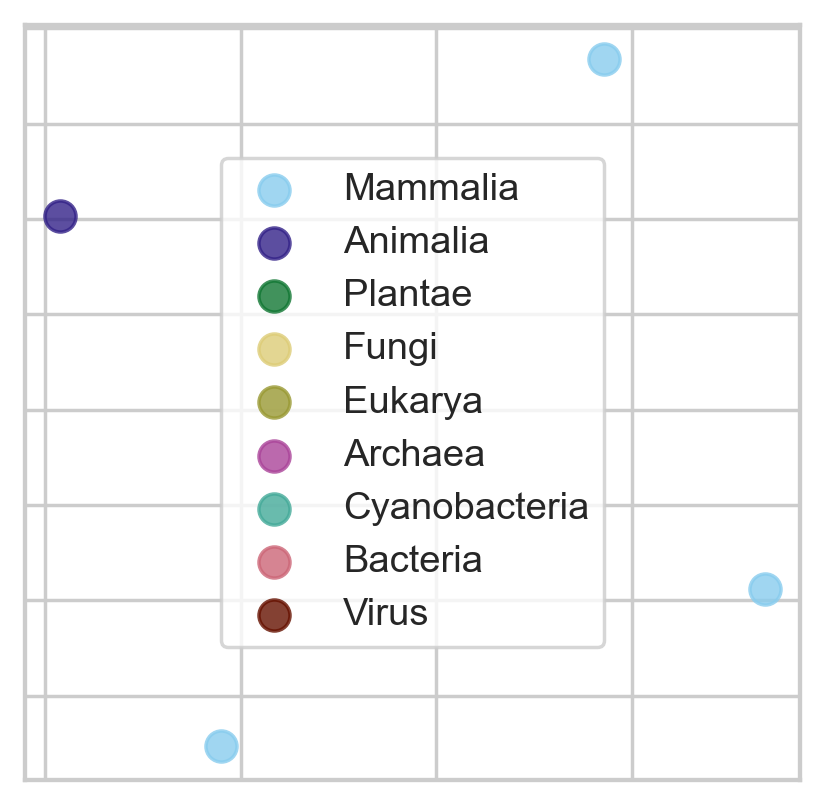

In [13]:
set_pub_plot_context(context="notebook")
fig = plt.figure(figsize=(4,4), dpi=250)
ax = fig.add_subplot(111)
colors = sns.color_palette()
names = ["Mammalia", "Animalia", 'Plantae', 'Fungi', 'Eukarya',
        'Archaea', 'Cyanobacteria', 'Bacteria', 'Virus'
        ]

color_idxs = [0,4,3,2,7,5,6,1,9]
colors = [colors[i] for i in color_idxs]
for i, name in enumerate(names):
    mask = organism_means.specific_names == name
    x = components[mask,0]
    y = components[mask,1]
    sns.regplot(x=x, y=y, fit_reg=False, ax=ax, color=colors[i], label=name, scatter_kws={"s":80})
    
ax.legend(fancybox=True, frameon=True)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

In [14]:
organism_mean_full = organism_means.copy()

In [15]:
# Now do a PCA just with select model organisms
organism_means = organism_mean_full.loc[[
    "human", "mouse","dog", "zebrafish"
], :]
pca = PCA(n_components=2)
components = pca.fit_transform(
    organism_means.mean_rep.tolist()
)

In [16]:
organism_means

,mean_rep,specific_names
organism,,
human,"[0.004102793, 0.027897034, 0.080792, -0.021301...",Mammalia
mouse,"[0.0045489008, -0.00036625017, 0.07418914, -0....",Mammalia
dog,"[0.00600221, -0.042912822, 0.027700389, -0.007...",Mammalia
zebrafish,"[0.0028931366, -0.022450926, 0.04616727, -0.01...",Animalia


[Text(0, -1.5, ''),
 Text(0, -1.0, ''),
 Text(0, -0.5, ''),
 Text(0, 0.0, ''),
 Text(0, 0.5, ''),
 Text(0, 1.0, ''),
 Text(0, 1.5, ''),
 Text(0, 2.0, '')]

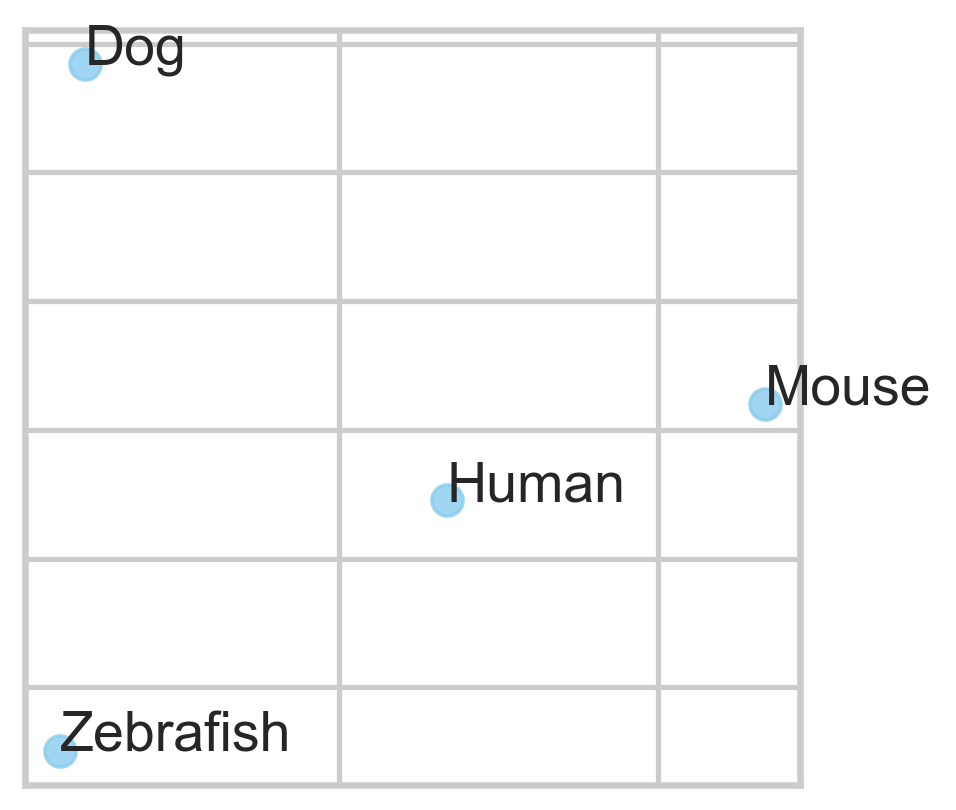

In [17]:
set_pub_plot_context()
fig = plt.figure(figsize=(4,4), dpi=250)
ax = fig.add_subplot(111)
x = components[:,0]
y = components[:,1]
sns.regplot(x=x, y=y, fit_reg=False, ax=ax)
pretty_names = ['Human', 
               'Mouse', 'Dog', 'Zebrafish'
               ]
label_point(pd.Series(x- .02),pd.Series(y),
            pd.Series(pretty_names)
            ,ax, fontsize=16)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
# Will edit colors and vectors in post